# Introduction

As the ever-changing landscape of the technology market in one of the most capitally-affluent nations begins to grow at rapid speeds beyond comprehension, the world watches and admires in how previous barriers to growth are almost immediately traversed with the ingenuity of emerging topics within machine learning, AI, and big data processes. However, among the many existing challenges within the market, the inability to accurately forecast and predict trends across multiple different latitudes have left high-level researchers and quantitative developers with numerous of unanswered questions and temporary solutions. Within this intersection of statistical modeling and machine learning, time series modeling allows users to model a time-correlated process and explore the impact of one of the most elusive, impactful predictors of any model, time itself. For the majority of the discipline's existence, stochastic models have dominated the methodology, harnessing Monte Carlo simulations and complex Markov chains to make accurate predictions to a somewhat fair degree. Primarily, these include ARIMA and SARIMA models, which model the influence of previous time points on current data. While robust to many troublesome patterns found within the average time series, their performative ability begins to decline with greater data complexity. Furthermore, parametric models, while accurate and reliable in their ideal conditions, always suffer from violated assumptions in modern-day applications. Among these violations is the lack of heteroskedasticity, which plagued models with inconsistent variance until Robert F. Engle's ARCH model $_{[1]}$ was born to combat its detrimental influence. 

As newly-explored innovations are being implemented to bridge the many gaps throughout predictive modeling, we would like to focus our attention on the 2017 research composition of Hristos Tyralis and Georgia Papacharalampous $_{[2]}$ which asserts the superior predictive ability of the random forest variable selection within the time series domain over their derived ACF and PACF counterparts. 

In order to advance our understanding of this topic, we will be expanding upon this study, utilizing the methodology of Tyralis and Papacharalampous to inspire our investigation into the effectiveness of random forest-engineered, multi-variate time series models in comparison to other contemporary methods. In addition to performing comparative measures of accuracy, we will be focusing our attention towards the unique attributes of the examined BCG Jena Weather Station Dataset from 2017-2024 $_{[3]}$, confronting the potential drawbacks from larger datasets with demonstrated seasonality.

## Table of Contents:

#### Data Processing

- Initialization of data and library imports for global use

#### Feature Engineering

Random Forest Model Fitting and Variable Selection 

### Contemporary Models and Predictive Forecasting:

#### Method 1: Random Forest Predictions

#### Method 2: Box-Jenkins ARIMA + SARIMA

#### Method 3: Auto-ARIMA

#### Method 4: Boosted Trees Fitting + Predictions

### Model Comparison 

- Mean Squared Error Comparison 

### References 


# Data Processing

In [170]:
import kagglehub
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

path = kagglehub.dataset_download("matthewjansen/bgc-jena-weather-station-dataset-20172024")
files = os.listdir(path)
csv_file = [file for file in files if file.endswith('.csv')]
dataset_path = os.path.join(path, csv_file[0])
df = pd.read_csv(dataset_path)
print(df)

                  Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0       2017-01-01 00:10:00    999.77     -4.91    268.27        -8.41   
1       2017-01-01 00:20:00    999.63     -5.05    268.13        -8.37   
2       2017-01-01 00:30:00    999.54     -4.98    268.21        -8.38   
3       2017-01-01 00:40:00    999.40     -4.88    268.33        -8.56   
4       2017-01-01 00:50:00    999.17     -5.17    268.06        -8.74   
...                     ...       ...       ...       ...          ...   
420777  2024-12-31 23:20:00    997.74     -0.78    272.55        -2.64   
420778  2024-12-31 23:30:00    997.81     -1.42    271.90        -2.71   
420779  2024-12-31 23:40:00    997.88     -1.41    271.90        -2.80   
420780  2024-12-31 23:50:00    997.92     -1.63    271.68        -2.96   
420781  2025-01-01 00:00:00    997.51     -1.54    271.81        -3.00   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  ...  \
0         76.3          4.24       

The BCG Jena Weather Station Dataset contains 22 measurements of weather related processes such as pressure, temperature, and namely, rainfall. For the sake of this project, we will be focussing on the rain measurements. In this particular dataset, rainfall is measured in 10 minute intervals. While informative, this scale doesn't present meaningful insights. Thus, we will convert the dataset to a month-by-month amount.

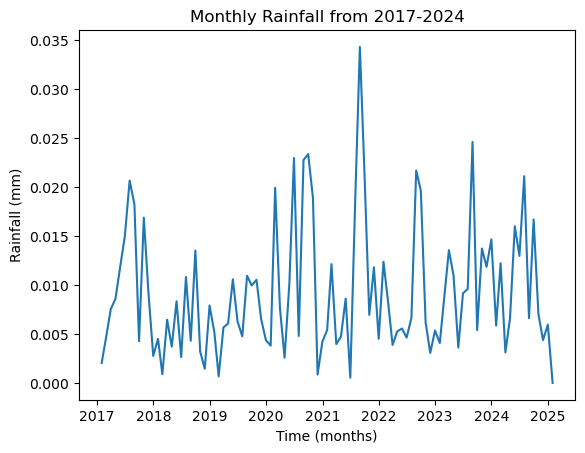

In [171]:
import pandas as pd

df = df[["Date Time", "rain (mm)"]]
df["datetime"] = pd.to_datetime(df["Date Time"])
df.set_index("datetime", inplace=True)
df = df["rain (mm)"].resample("ME").mean().to_frame(name="Rainfall")

plt.plot(df)
plt.xlabel("Time (months)")
plt.ylabel("Rainfall (mm)")
plt.title("Monthly Rainfall from 2017-2024")
plt.show()

# Feature Engineering

We will first proceed by creating feature variables for the random forest model. More specifically, we will create lagged vectors for the autoregressive component and rolling average vectors for the moving average component. We are utilizing the following naming scheme:

Autoregressive Components: $y_{(t-h)}$

Moving Average Components: $z_{(t-h)}$

where h is the lag.

In [172]:
df["y(t-1)"] = df["Rainfall"].shift(1)
df["y(t-2)"] = df["Rainfall"].shift(2)
df["y(t-3)"] = df["Rainfall"].shift(3)
df["y(t-6)"] = df["Rainfall"].shift(6)
df["y(t-12)"] = df["Rainfall"].shift(12)

df['z(t-1)'] = df['Rainfall'].rolling(window=1).mean()
df['z(t-2)'] = df['Rainfall'].rolling(window=2).mean()
df['z(t-3)'] = df['Rainfall'].rolling(window=3).mean()
df['z(t-6)'] = df['Rainfall'].rolling(window=6).mean()
df['z(t-12)'] = df['Rainfall'].rolling(window=12).mean()

print(df)

            Rainfall    y(t-1)    y(t-2)    y(t-3)    y(t-6)   y(t-12)  \
datetime                                                                 
2017-01-31  0.002039       NaN       NaN       NaN       NaN       NaN   
2017-02-28  0.004613  0.002039       NaN       NaN       NaN       NaN   
2017-03-31  0.007549  0.004613  0.002039       NaN       NaN       NaN   
2017-04-30  0.008565  0.007549  0.004613  0.002039       NaN       NaN   
2017-05-31  0.011873  0.008565  0.007549  0.004613       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-09-30  0.016690  0.006608  0.021102  0.012963  0.003114  0.005394   
2024-10-31  0.007034  0.016690  0.006608  0.021102  0.006597  0.013718   
2024-11-30  0.004375  0.007034  0.016690  0.006608  0.015995  0.011852   
2024-12-31  0.005959  0.004375  0.007034  0.016690  0.012963  0.014651   
2025-01-31  0.000000  0.005959  0.004375  0.007034  0.021102  0.005847   

              z(t-1)    z(t-2)    z(t

## Random Forest Model Fitting

Tyralis and Papacharalampous suggest using 500 trees for the Random Forest model as a medium between Kuhn and Johnson $_{[4]}$, and Probst and Boulesteix $_{[5]}$, who suggest 1000 and 100 trees, respectively.

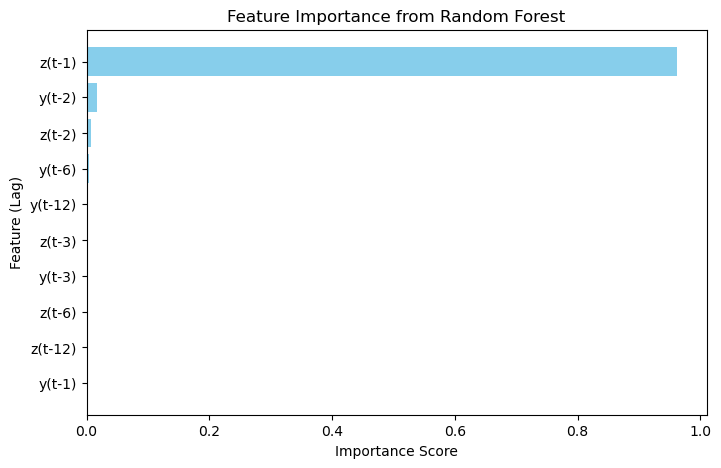

In [173]:
df.dropna(inplace=True)

X = df.drop("Rainfall", axis=1)
y = df["Rainfall"]

rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df.sort_values(by="Importance", ascending=False, inplace=True)

plt.figure(figsize=(8, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature (Lag)")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()
plt.show()


The above plot depicts the results of the Random Forest model fit. We observe that it highly favors the lag 1 moving average component, with the lag 2 autoregressive and lag 2 moving average components holding a residual degree of importance. Thus, we will fit the following time series models:

1. MA(1)

2. AR(2)

3. MA(2)

4. ARMA(1,2)

5. ARMA(2,2)

## Fitting Time Series Models

We will now create training and testing sets with the cutoff beginning at the first of the final 12 months.

In [174]:
split_date = df.index[-12]

df_train = df.loc[:split_date]
df_test = df.loc[split_date:]

X_train, y_train = df_train.drop(columns=["Rainfall"]), df_train["Rainfall"]
X_test, y_test = df_test.drop(columns=["Rainfall"]), df_test["Rainfall"]

forecast_start = y_test.index[0]
forecast_end = y_test.index[-1]

The training-testing split is visualized below.

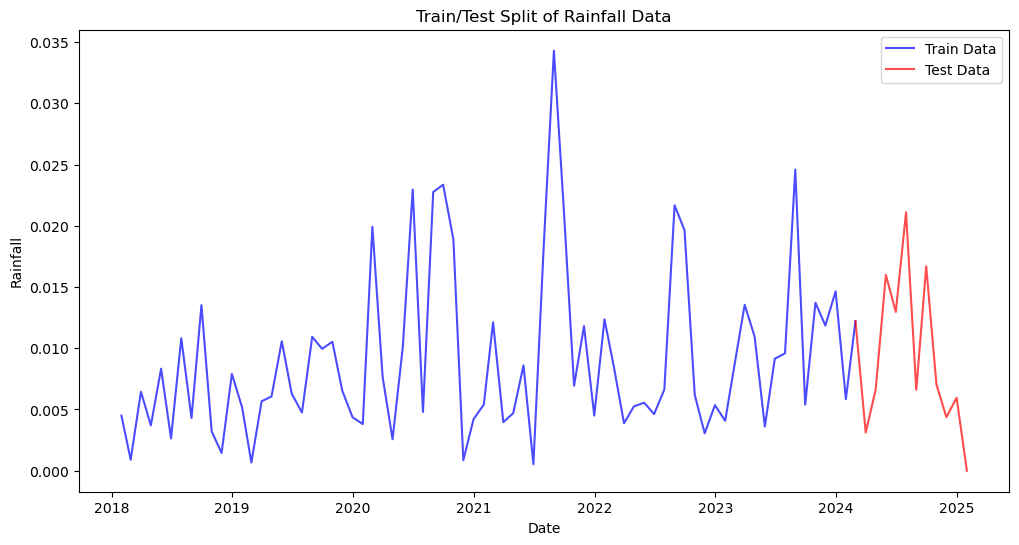

In [175]:
train_index = y_train.index
test_index = y_test.index

plt.figure(figsize=(12, 6))
plt.plot(train_index, y_train, label="Train Data", color="blue", alpha=0.7)
plt.plot(test_index, y_test, label="Test Data", color="red", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.title("Train/Test Split of Rainfall Data")
plt.legend()
plt.show()

## Method 1: Random Forest

In [176]:
rf_ma_1 = ARIMA(y_train, order = (0,0,1)).fit()
rf_pred = rf_ma_1.predict(start=forecast_start,end=forecast_end)

### Method 2: Box-Jenkins

                               SARIMAX Results                                
Dep. Variable:               Rainfall   No. Observations:                   74
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 267.780
Date:                Mon, 17 Mar 2025   AIC                           -529.560
Time:                        22:49:26   BIC                           -522.648
Sample:                    01-31-2018   HQIC                          -526.802
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0091      0.001      7.301      0.000       0.007       0.012
ma.L1          0.2568      0.088      2.903      0.004       0.083       0.430
sigma2      4.207e-05   7.52e-06      5.596      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                           Rainfall   No. Observations:                   74
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 271.425
Date:                            Mon, 17 Mar 2025   AIC                           -532.850
Time:                                    22:49:26   BIC                           -521.330
Sample:                                01-31-2018   HQIC                          -528.254
                                     - 02-29-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0090      0.002      5.710      0.000       0.006       0.012
ar.L1          0.1415      0.111   

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


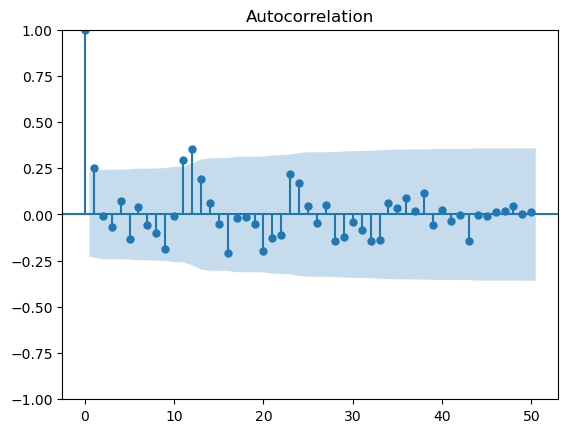

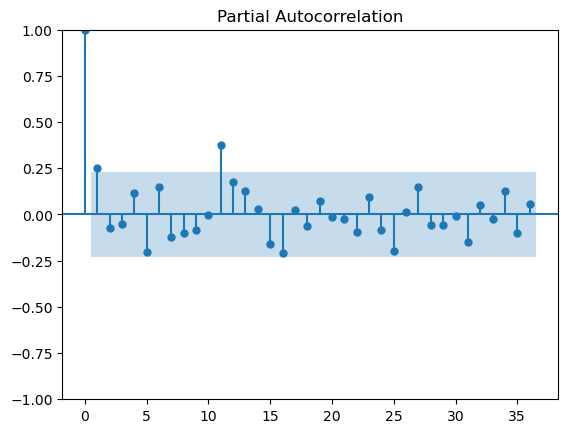

In [177]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_acf


# Data is stationary, check ACF and PACF
acf_vals = plot_acf(y_train, lags=50)
pacf_vals = plot_pacf(y_train, lags=36)

# ACF Results: MA could potentially be 0 or 1
# PACF Results: AR could potentially be 0 or 1


# ARIMA Fitting: 
bj_ma_model = ARIMA(y_train, order=(0, 0, 1))
bj_ar_model = ARIMA(y_train, order=(1, 0, 0))
bj_arma_model = ARIMA(y_train, order=(1, 0, 1))

print(bj_ma_model.fit().summary())
print(bj_ar_model.fit().summary())
print(bj_arma_model.fit().summary())


# SARIMA Fitting:
sbj_ma_model = ARIMA(y_train, order=(0,0,1), seasonal_order=(1,0,1,12)) # best model
sbj_ar_model = ARIMA(y_train, order=(1,0,0), seasonal_order=(1,0,1,12))
sbj_arma_model = ARIMA(y_train, order=(1,0,1), seasonal_order=(1,0,1,12))

print(sbj_ma_model.fit().summary())
print(sbj_ar_model.fit().summary())
print(sbj_arma_model.fit().summary())

# For future predictions
auto_arima_pred = sbj_ma_model.fit().predict(start=forecast_start,end=forecast_end)

## Method 3: Auto Arima Fitting

Test 1: Monthly Model Summary
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   74
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                 271.339
Date:                             Mon, 17 Mar 2025   AIC                           -534.678
Time:                                     22:50:49   BIC                           -525.461
Sample:                                 01-31-2018   HQIC                          -531.001
                                      - 02-29-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0060      0.001      4.079      0.000       0.003       0.0

/var/folders/p6/yrg12s_n51502gr1hzkzdz840000gn/T/ipykernel_91521/667136908.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_index = pd.date_range(start=y_train.index[-1],periods=12,freq="M")


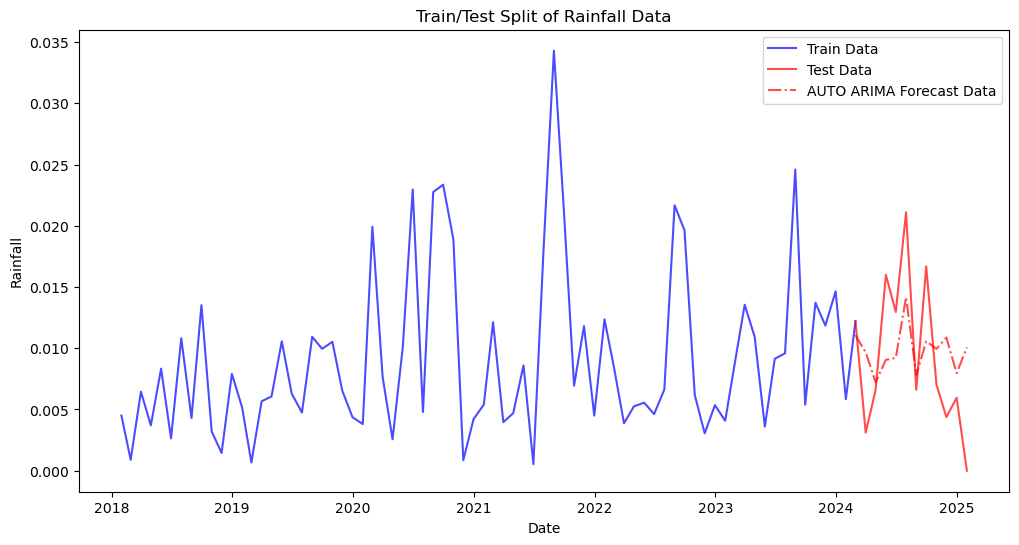

In [180]:
# AUTO ARIMA Coding Module
from pmdarima import auto_arima
## Model-Fitting Procedures
monthly_model = auto_arima(y_train,seasonal=True,trace=False,suppress_warnings=True,stepwise=True,m=12,stationary=False,information_criterion='aic', random_state=1)

print("Test 1: Monthly Model Summary")
print(monthly_model.summary())
print("\n")

## Forecasting 
monthly_forecast = monthly_model.predict(n_periods=len(test_index))
data_index = pd.date_range(start=y_train.index[-1],periods=12,freq="M")
monthly_series_forecast = pd.Series(monthly_forecast,index=data_index)


# Comparable Visualization 
plt.figure(figsize=(12, 6))
plt.plot(train_index, y_train, label="Train Data", color="blue", alpha=0.7)
plt.plot(test_index, y_test, label="Test Data", color="red", alpha=0.7)
plt.plot(test_index, monthly_forecast, label="AUTO ARIMA Forecast Data", color="red", alpha=0.7,ls="-.")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.title("Train/Test Split of Rainfall Data")
plt.legend()
plt.show()

## Model Comparison

In [181]:
rf_mse = mean_squared_error(rf_pred, y_test)
box_jenkins_mse = mean_squared_error(box_jenkins_pred, y_test)
auto_arima_mse = mean_squared_error(auto_arima_pred, y_test)

mse = [["Random Forest", rf_mse], ["Box-Jenkins", box_jenkins_mse], ["Auto ARIMA", auto_arima_mse]]
df = pd.DataFrame(mse, columns=["Method", "Mean Squared Error"])
print(df)

          Method  Mean Squared Error
0  Random Forest            0.000039
1    Box-Jenkins            0.000047
2     Auto ARIMA            0.000047


## To-do

1. Getting title, names, date, etc. header organized for this file
2. ~~Decide on other models to compare to (eg. ARIMA, SARIMA, ARCH, etc.)~~
3. ~~Set up Random Forest Regressor (Brooks can do this)~~
4. Set up other models
5. Decide on comparison metric (eg. MSE, RMSE, etc.)
6. Compare models

# References

1. Engle, R. F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. Econometrica, 50(4), 987–1007. The Econometric Society. https://doi.org/10.2307/1912773.

2. Tyralis, H., & Papacharalampous, G. (2017). Variable Selection in Time Series Forecasting Using Random Forests. Algorithms, 10(4), 114. https://doi.org/10.3390/a10040114

3. Jansen, M. (2024). BGC Jena weather station dataset (2017–2024) [Dataset]. Kaggle. https://www.kaggle.com/datasets/matthewjansen/bgc-jena-weather-station-dataset-20172024.

4. Kuhn, M.; Johnson, K. Applied Predictive Modeling; Springer: New York, NY, USA, 2013. [Google Scholar]

5. Probst, P.; Boulesteix, A.L. To tune or not to tune the number of trees in random forest? arXiv 2017, arXiv:1705.05654v1. [Google Scholar]